# Método de Metropolis–Hastings para Inferencia Bayesiana en Black–Scholes  

# Importaciones y configuración general

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import warnings
from scripts import style
style.mpl_apply()

warnings.filterwarnings("ignore")

# Semilla global para reproducibilidad
np.random.seed(0)


# Carpetas de salida
root = Path("09 Metropolis-Hastings para Inferencia Bayesiana en Black-Scholes")
figures_dir = root / "figures"
results_dir = root / "results"
figures_dir.mkdir(exist_ok=True)
results_dir.mkdir(exist_ok=True)

# Generación de datos sintéticos (GBM)

Modelo:

$$
dS_t=\mu S_t\,dt+\sigma S_t\,dW_t
$$

Discretizando en log-retornos:

$$
x_t=\log\frac{S_{t+1}}{S_t}\sim\mathcal{N}\big((\mu-\tfrac12\sigma^2)\Delta t,\ \sigma^2\Delta t\big)
$$

Simulamos una trayectoria diaria de un año.


In [2]:
mu_true = 0.08
sigma_true = 0.25
S0 = 100
T = 1.0
n_obs = 252

dt = T / n_obs
t_grid = np.linspace(0, T, n_obs + 1)

# Para fijar la muestra simulada
np.random.seed(42)

dW = np.random.normal(0, np.sqrt(dt), n_obs)
log_returns = (mu_true - 0.5 * sigma_true**2) * dt + sigma_true * dW
S_t = S0 * np.exp(np.cumsum(np.concatenate([[0], log_returns])))

precios_observados = S_t[1:]

print("Parámetros verdaderos:")
print(f"  μ = {mu_true:.4f}, σ = {sigma_true:.4f}, S0 = {S0:.2f}")
print(f"  T = {T} año, n_obs = {n_obs}")
print()
print("Estadísticas observadas:")
print(f"  S_T final     = {S_t[-1]:.2f}")
print(f"  Precio medio  = {np.mean(precios_observados):.2f}")
print(f"  Retorno anual = {np.log(S_t[-1]/S0)/T:.4f}")


Parámetros verdaderos:
  μ = 0.0800, σ = 0.2500, S0 = 100.00
  T = 1.0 año, n_obs = 252

Estadísticas observadas:
  S_T final     = 103.44
  Precio medio  = 92.65
  Retorno anual = 0.0338


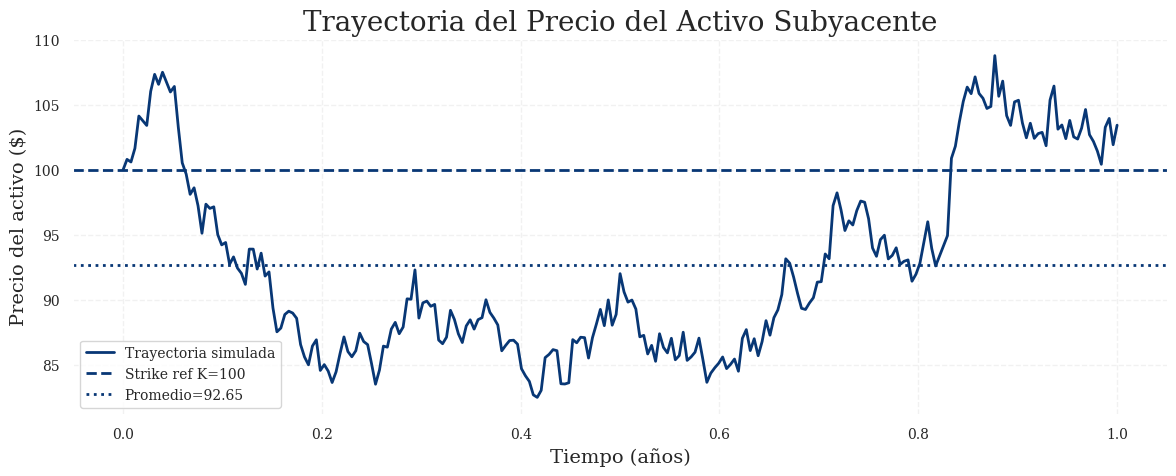

In [3]:
K_plot = 100  # solo para referencia visual aquí

fig1, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_grid, S_t, linewidth=2, label="Trayectoria simulada")
ax.axhline(K_plot, linestyle="--", linewidth=2, label=f"Strike ref K={K_plot}")
ax.axhline(np.mean(precios_observados), linestyle=":", linewidth=2,
           label=f"Promedio={np.mean(precios_observados):.2f}")

ax.set_xlabel("Tiempo (años)")
ax.set_ylabel("Precio del activo ($)")
ax.set_title("Trayectoria del Precio del Activo Subyacente")
ax.legend()
ax.grid(True, alpha=0.3)

fig1.tight_layout()
fig1_path = figures_dir / "fig1_trayectoria_precios.pdf"
fig1.savefig(fig1_path, bbox_inches="tight")

plt.show()


# Modelo estadístico/bayesiano

**Modelo del subyacente (medida física $\mathbb{P}$):**

$$
dS_t=\mu S_t\,dt+\sigma S_t\,dW_t .
$$

Aplicando Itô a $\log S_t$:

$$
d(\log S_t)=\left(\mu-\frac{\sigma^2}{2}\right)dt+\sigma\,dW_t .
$$

En discretización diaria con paso $\Delta t$:

$$
r_t:=\log\left(\frac{S_{t+\Delta t}}{S_t}\right)\sim
N\left(\left(\mu-\frac{\sigma^2}{2}\right)\Delta t,\ \sigma^2\Delta t\right) .
$$

**Verosimilitud (log-retornos iid):**

$$
p(\mathbf r\mid \mu,\sigma)=
\prod_{i=1}^n\frac{1}{\sqrt{2\pi\sigma^2\Delta t}}
\exp\left(-\frac{(r_i-m)^2}{2\sigma^2\Delta t}\right),
$$

donde $m=\left(\mu-\frac{\sigma^2}{2}\right)\Delta t$.

**Priors débilmente informativos:**

$$
\mu\sim N(0,1),\qquad
\sigma\sim \text{InvGamma}(2,0.1).
$$

**Posterior:**

$$
p(\mu,\sigma\mid\mathbf r)\propto
p(\mathbf r\mid\mu,\sigma)\ p(\mu)\ p(\sigma).
$$


In [4]:
log_retornos = np.diff(np.log(S_t))

print("Número de log-retornos:", len(log_retornos))
print("Primeros 5 log-retornos:", log_retornos[:5])


Número de log-retornos: 252
Primeros 5 log-retornos: [ 0.00801597 -0.00198401  0.01039359  0.02417892 -0.00349412]


# Log-posterior

$$
\log p(\mu,\sigma\mid \mathbf r)=
\log p(\mathbf r\mid\mu,\sigma)+\log p(\mu)+\log p(\sigma)+C
$$

El término $C$ es constante y se ignora en M–H.


In [5]:
def log_posterior(theta, log_retornos, dt):
    # Log-posterior sin constante normalizante
    mu, sigma = theta

    # sigma debe ser positiva
    if sigma <= 0:
        return -np.inf

    # Likelihood Normal iid
    media = (mu - 0.5 * sigma**2) * dt
    var = sigma**2 * dt

    log_lik = -0.5 * len(log_retornos) * np.log(2*np.pi*var)
    log_lik -= 0.5 * np.sum((log_retornos - media)**2) / var

    # Prior mu ~ N(0,1)
    log_prior_mu = -0.5*np.log(2*np.pi) - 0.5*mu**2

    # Prior sigma ~ InvGamma(2,0.1)
    alpha, beta = 2, 0.1
    log_prior_sigma = alpha*np.log(beta) - (alpha+1)*np.log(sigma) - beta/sigma

    return log_lik + log_prior_mu + log_prior_sigma


# Descripción del método Metropolis–Hastings

Metropolis–Hastings (M–H) genera muestras de una distribución objetivo $\pi(\theta)$ conocida hasta constante normalizante.

**Definición (distribución estacionaria)**  
Una cadena de Markov con matriz de transición $P$ tiene distribución estacionaria $\pi$ si:

$$
\pi P = \pi .
$$

**Algoritmo M–H (idea)**  
Generamos una propuesta $\theta^*$ desde $q(\theta^*\mid\theta)$ y aceptamos con probabilidad $\alpha$:

$$
\alpha=\min\left(1,\frac{\pi(\theta^*)\,q(\theta\mid\theta^*)}{\pi(\theta)\,q(\theta^*\mid\theta)}\right).
$$

En este proyecto usamos **Random Walk Metropolis**:

$$
\theta^*=\theta+\epsilon,\qquad \epsilon\sim N(0,\Sigma),
$$

que es simétrico, así que $q(\theta^*\mid\theta)=q(\theta\mid\theta^*)$ y queda:

$$
\alpha=\min\left(1,\frac{\pi(\theta^*)}{\pi(\theta)}\right).
$$


In [6]:
def metropolis_hastings(log_posterior_fn, theta_init, n_iter, proposal_sd,
                        data, dt, burn_in=1000):
    # Random-Walk Metropolis–Hastings
    n_params = len(theta_init)
    samples_full = np.zeros((n_iter, n_params))
    samples_full[0] = theta_init
    n_accepted = 0

    for i in range(1, n_iter):
        theta_current = samples_full[i-1]
        theta_proposal = theta_current + np.random.normal(0, proposal_sd, n_params)

        log_post_current = log_posterior_fn(theta_current, data, dt)
        log_post_proposal = log_posterior_fn(theta_proposal, data, dt)

        log_alpha = log_post_proposal - log_post_current

        if np.log(np.random.uniform()) < log_alpha:
            samples_full[i] = theta_proposal
            n_accepted += 1
        else:
            samples_full[i] = theta_current

    acceptance_rate = n_accepted / n_iter
    samples_post = samples_full[burn_in:]
    return samples_full, samples_post, acceptance_rate


n_iterations = 30000
burn_in = 5000
theta_inicial = np.array([0.05, 0.30])
proposal_sd = np.array([0.01, 0.01])

samples_full, samples, acceptance_rate = metropolis_hastings(
    log_posterior, theta_inicial, n_iterations, proposal_sd,
    log_retornos, dt, burn_in
)

print(f"Tasa de aceptación: {acceptance_rate:.3f}")
print(f"Muestras útiles: {len(samples):,}")


Tasa de aceptación: 0.721
Muestras útiles: 25,000


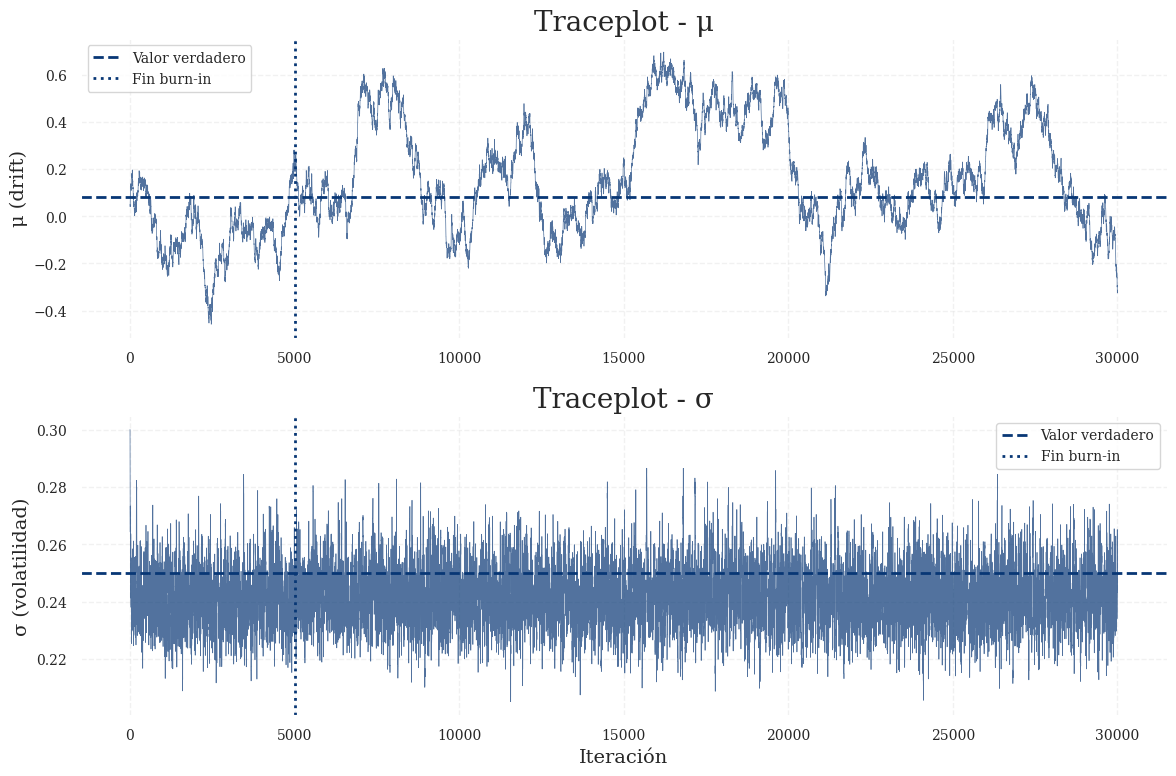

In [7]:
fig2, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(samples_full[:, 0], linewidth=0.5, alpha=0.7)
axes[0].axhline(mu_true, linestyle="--", linewidth=2, label="Valor verdadero")
axes[0].axvline(burn_in, linestyle=":", linewidth=2, label="Fin burn-in")
axes[0].set_ylabel("μ (drift)")
axes[0].set_title("Traceplot - μ")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(samples_full[:, 1], linewidth=0.5, alpha=0.7)
axes[1].axhline(sigma_true, linestyle="--", linewidth=2, label="Valor verdadero")
axes[1].axvline(burn_in, linestyle=":", linewidth=2, label="Fin burn-in")
axes[1].set_xlabel("Iteración")
axes[1].set_ylabel("σ (volatilidad)")
axes[1].set_title("Traceplot - σ")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig2.tight_layout()
fig2_path = figures_dir / "fig2_traceplots.pdf"
fig2.savefig(fig2_path, bbox_inches="tight")

plt.show()


# Resultados posteriores de $\mu$ y $\sigma$

Calculamos estimadores puntuales (media, mediana) e IC creíbles 95%.  
Comparamos contra MLE clásico del GBM.


In [8]:
mu_posterior = samples[:, 0]
sigma_posterior = samples[:, 1]

mu_mean, mu_median = np.mean(mu_posterior), np.median(mu_posterior)
sigma_mean, sigma_median = np.mean(sigma_posterior), np.median(sigma_posterior)

mu_ci = np.percentile(mu_posterior, [2.5, 97.5])
sigma_ci = np.percentile(sigma_posterior, [2.5, 97.5])

# MLE GBM
mu_mle = np.mean(log_retornos)/dt + 0.5*np.var(log_retornos)/dt
sigma_mle = np.sqrt(np.var(log_retornos)/dt)

resultados = {
    "Parámetro": ["μ (drift)", "σ (volatilidad)"],
    "Valor Verdadero": [mu_true, sigma_true],
    "Media Posterior": [mu_mean, sigma_mean],
    "Mediana Posterior": [mu_median, sigma_median],
    "IC 2.5%": [mu_ci[0], sigma_ci[0]],
    "IC 97.5%": [mu_ci[1], sigma_ci[1]],
    "Estimación MLE": [mu_mle, sigma_mle],
}

df_resultados = pd.DataFrame(resultados)
display(df_resultados)

res_path = results_dir / "resultados_parametros.csv"
df_resultados.to_csv(res_path, index=False)

,Parámetro,Valor Verdadero,Media Posterior,Mediana Posterior,IC 2.5%,IC 97.5%,Estimación MLE
0,μ (drift),0.08,0.204112,0.164124,-0.154214,0.594597,0.062927
1,σ (volatilidad),0.25,0.242159,0.241795,0.221868,0.264972,0.241324


1. **$\sigma$ se estima con alta precisión**: su IC es estrecho y la media posterior casi coincide con MLE.  
2. **$\mu$ tiene mucha más incertidumbre (IC amplio)**: es más difícil estimar retorno esperado con datos finitos.  
3. **Riesgo de modelo**: la incertidumbre en $\mu$ domina la dispersión de precios de la opción, relevante actuarialmente.


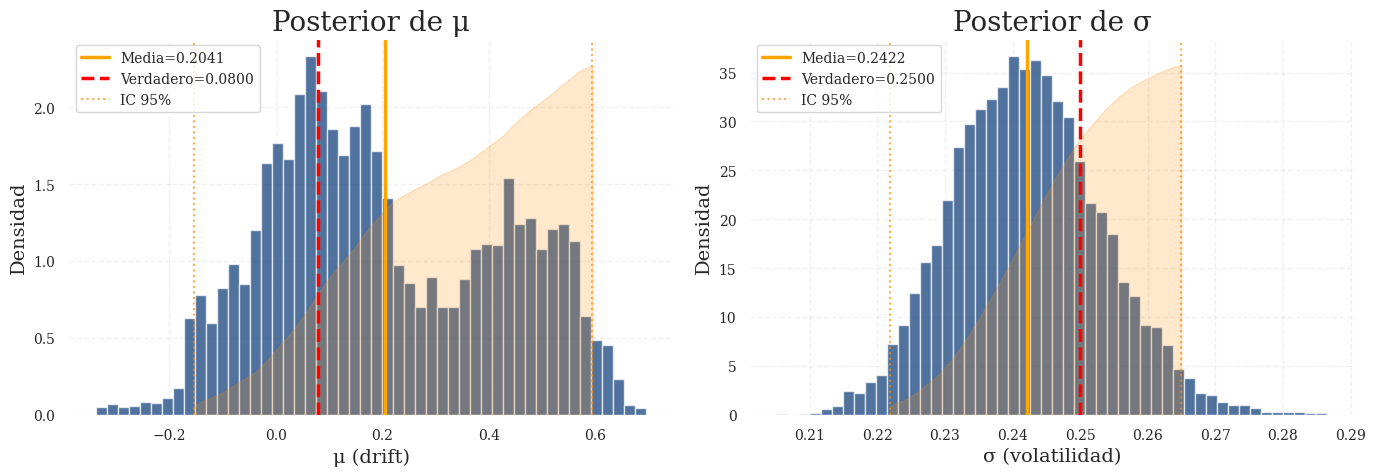

In [9]:
fig3, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(mu_posterior, bins=50, density=True, alpha=0.7)
# add fill to the area under the curve between mu_ci[0] and mu_ci[1]
x = np.linspace(mu_ci[0], mu_ci[1], 100)
axes[0].fill_between(x, 0, np.interp(x, np.sort(mu_posterior), np.linspace(0, 1, len(mu_posterior)))* max(np.histogram(mu_posterior, bins=50, density=True)[0]), color='darkorange', alpha=0.2)
axes[0].axvline(mu_mean, linewidth=2.5, label=f"Media={mu_mean:.4f}", color='orange')
axes[0].axvline(mu_true, linestyle="--", linewidth=2.5, label=f"Verdadero={mu_true:.4f}", color='red')
axes[0].axvline(mu_ci[0], linestyle=":", linewidth=1.5, alpha=0.7, color='darkorange')
axes[0].axvline(mu_ci[1], linestyle=":", linewidth=1.5, alpha=0.7, label="IC 95%", color='darkorange')
axes[0].set_xlabel("μ (drift)")
axes[0].set_ylabel("Densidad")
axes[0].set_title("Posterior de μ")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(sigma_posterior, bins=50, density=True, alpha=0.7)
# add fill to the area under the curve between mu_ci[0] and mu_ci[1]
x = np.linspace(sigma_ci[0], sigma_ci[1], 100)
axes[1].fill_between(x, 0, np.interp(x, np.sort(sigma_posterior), np.linspace(0, 1, len(sigma_posterior)))* max(np.histogram(sigma_posterior, bins=50, density=True)[0]), color='darkorange', alpha=0.2)
axes[1].axvline(sigma_mean, linewidth=2.5, label=f"Media={sigma_mean:.4f}", color='orange')
axes[1].axvline(sigma_true, linestyle="--", linewidth=2.5, label=f"Verdadero={sigma_true:.4f}", color='red')
axes[1].axvline(sigma_ci[0], linestyle=":", linewidth=1.5, alpha=0.7, color='darkorange')
axes[1].axvline(sigma_ci[1], linestyle=":", linewidth=1.5, alpha=0.7, label="IC 95%", color='darkorange')
axes[1].set_xlabel("σ (volatilidad)")
axes[1].set_ylabel("Densidad")
axes[1].set_title("Posterior de σ")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig3.tight_layout()
fig3_path = figures_dir / "fig3_distribuciones_posteriores.pdf"
fig3.savefig(fig3_path, bbox_inches="tight")

plt.show()


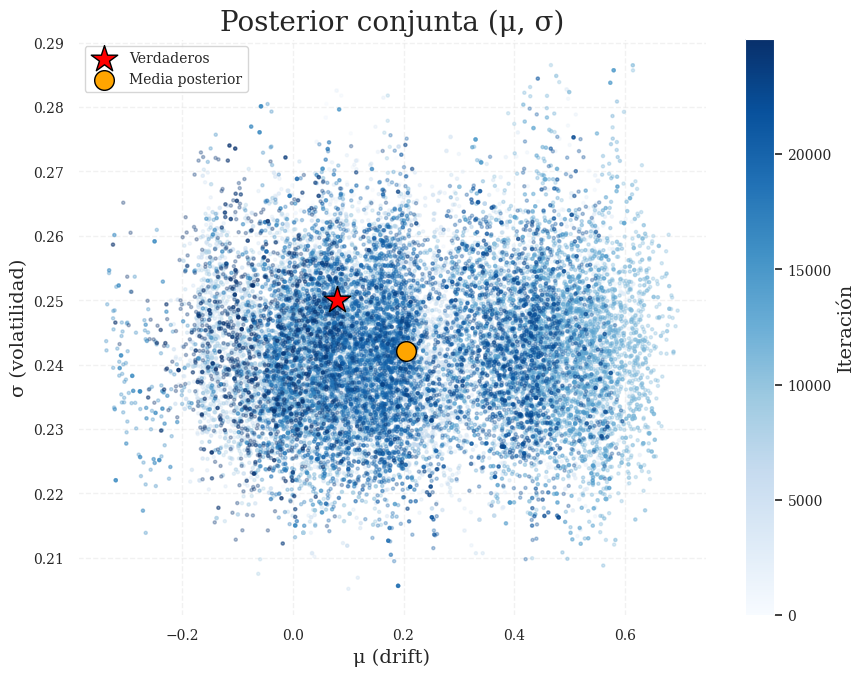

In [10]:
fig6, ax = plt.subplots(figsize=(9, 7))

scatter = ax.scatter(mu_posterior, sigma_posterior,
                     c=np.arange(len(mu_posterior)),
                     cmap="Blues",
                     alpha=0.3, s=5)

ax.scatter(mu_true, sigma_true, color="red", s=400, marker="*",
           edgecolors="black", linewidths=1, label="Verdaderos", zorder=5)

ax.scatter(mu_mean, sigma_mean, color="orange", s=200, marker="o",
           edgecolors="black", linewidths=1, label="Media posterior", zorder=5)

ax.set_xlabel("μ (drift)")
ax.set_ylabel("σ (volatilidad)")
ax.set_title("Posterior conjunta (μ, σ)")
ax.legend()
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax, label="Iteración")
cbar.solids.set_alpha(1)

fig6.tight_layout()
fig6_path = figures_dir / "fig6_joint_posterior.pdf"
fig6.savefig(fig6_path, bbox_inches="tight")

plt.show()


Con los datos simulados bajo un GBM con parámetros verdaderos $\mu_{\text{true}}=0.08$ y $\sigma_{\text{true}}=0.25$, se generó una trayectoria diaria de $n_{\text{obs}}=252$ observaciones en $T=1$ año, iniciando en $S_0=100$. Las estadísticas observadas fueron:

- Precio final $S_T=103.44$
- Precio medio $\bar S=92.65$
- Retorno anualizado observado $\log(S_T/S_0)/T = 0.0338$

A partir de los log-retornos discretos
$$
r_t=\log\left(\frac{S_{t+\Delta t}}{S_t}\right),\qquad \Delta t=T/n_{\text{obs}},
$$
se obtuvieron 252 log-retornos (primeros 5: $[0.0080,-0.0020,0.0104,0.0242,-0.0035]$). Bajo el modelo
$$
r_t \mid \mu,\sigma \sim \mathcal N\!\left(\left(\mu-\frac{\sigma^2}{2}\right)\Delta t,\ \sigma^2\Delta t\right),
$$
y priors débiles $\mu\sim \mathcal N(0,1)$, $\sigma \sim \text{InvGamma}(2,0.1)$, la posterior conjunta $p(\mu,\sigma\mid \mathbf r)$ se exploró con Metropolis–Hastings.

**Lectura de las marginales posteriores (Figuras de “Posterior de $\mu$” y “Posterior de $\sigma$”).**

- **Posterior de $\sigma$ (volatilidad):** la distribución es unimodal, concentrada y aproximadamente simétrica alrededor de $\sigma\approx 0.24$–$0.25$. Esto es esperable porque la volatilidad controla directamente la varianza de los retornos, y dicha varianza se identifica con relativa facilidad incluso en muestras moderadas. En términos prácticos: *los datos contienen mucha más información sobre dispersión que sobre tendencia*.

- **Posterior de $\mu$ (drift):** aparece mucho más ancha, con asimetría y colas notables. Esto refleja un hecho clásico en finanzas: el drift es difícil de estimar con precisión a horizonte anual usando 252 observaciones diarias, ya que su efecto en el retorno medio es pequeño comparado con el ruido inducido por $\sigma$. La posterior amplia implica que un rango amplio de drifts es compatible con la misma trayectoria observada.

**Comparación Bayes vs. MLE.**

La MLE para GBM basada en retornos discretos es
$$
\hat\sigma^2_{\text{MLE}}=\frac{1}{\Delta t}\,\widehat{\mathrm{Var}}(r_t),\qquad
\hat\mu_{\text{MLE}}=\frac{1}{\Delta t}\,\bar r +\frac{1}{2}\hat\sigma^2_{\text{MLE}},
$$
donde $\bar r$ es la media muestral de $r_t$. En este experimento, $\hat\sigma_{\text{MLE}}$ resulta casi idéntica a la media posterior de $\sigma$, mientras que $\hat\mu_{\text{MLE}}$ difiere de la media posterior de $\mu$. No es contradicción: la MLE es un punto que maximiza verosimilitud, mientras que la media posterior integra toda la masa de probabilidad ponderada por priors; si la posterior es muy dispersa/asimétrica (como en $\mu$), la media y el máximo pueden separarse.

En síntesis: **$\sigma$ queda bien estimada y estable en ambos enfoques; $\mu$ conserva incertidumbre estructural que solo el enfoque bayesiano exhibe explícitamente.**


# Diagnósticos MCMC

- Autocorrelación por lag.  
- ESS aproximado:

$$
\text{ESS}\approx \frac{n}{1+2\sum_{k=1}^{K}\rho_k}
$$

**Interpretación**  
- Alta autocorrelación en $\mu$ implica ESS bajo.  
- $\sigma$ mezcla mejor y tiene ESS mayor.


In [11]:
def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

lags = range(1, 51)
autocorr_mu = [autocorr(mu_posterior, lag) for lag in lags]
autocorr_sigma = [autocorr(sigma_posterior, lag) for lag in lags]

def effective_sample_size(x, max_lag=50):
    n = len(x)
    max_lag = min(max_lag, n//2)
    ac_sum = sum(autocorr(x, lag) for lag in range(1, max_lag))
    return n / (1 + 2 * ac_sum)

ess_mu = effective_sample_size(mu_posterior)
ess_sigma = effective_sample_size(sigma_posterior)

diagnosticos = {
    "Métrica": ["Tasa de aceptación", "ESS μ", "ESS σ", "Autocorr(1) μ", "Autocorr(1) σ"],
    "Valor": [
        f"{acceptance_rate:.3f}",
        f"{ess_mu:.0f}",
        f"{ess_sigma:.0f}",
        f"{autocorr_mu[0]:.4f}",
        f"{autocorr_sigma[0]:.4f}",
    ],
}

df_diagnosticos = pd.DataFrame(diagnosticos)
display(df_diagnosticos)

diag_path = results_dir / "diagnosticos_mcmc.csv"
df_diagnosticos.to_csv(diag_path, index=False)

,Métrica,Valor
0,Tasa de aceptación,0.721
1,ESS μ,258
2,ESS σ,2601
3,Autocorr(1) μ,0.9992
4,Autocorr(1) σ,0.8059


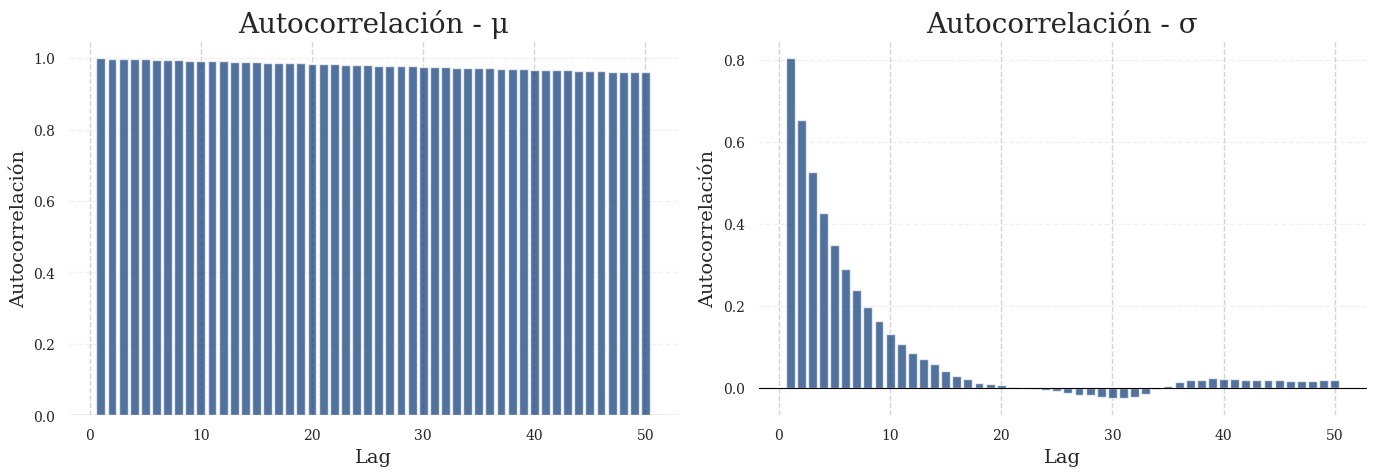

In [12]:
fig4, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(list(lags), autocorr_mu, alpha=0.7)
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelación")
axes[0].set_title("Autocorrelación - μ")
axes[0].grid(True, alpha=0.3, axis="y")

axes[1].bar(list(lags), autocorr_sigma, alpha=0.7)
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelación")
axes[1].set_title("Autocorrelación - σ")
axes[1].grid(True, alpha=0.3, axis="y")

fig4.tight_layout()
fig4_path = figures_dir / "fig4_autocorrelacion.pdf"
fig4.savefig(fig4_path, bbox_inches="tight")

plt.show()


El algoritmo Metropolis–Hastings se ejecutó con 30,000 iteraciones, burn-in de 5,000, y propuesta tipo random-walk con desviación estándar $[0.01,0.01]$. Se obtuvo:

- **Tasa de aceptación:** $0.721$
- **Muestras útiles:** $25{,}000$

Una aceptación de 72% es alta para un random-walk bivariado. En baja dimensión puede ser aceptable, pero suele indicar pasos efectivos pequeños: se aceptan muchas propuestas porque los saltos son cortos, lo que suele aumentar autocorrelación.

**Traceplots (Figura de traceplots).**

- Para $\sigma$, el traceplot oscila rápidamente alrededor del valor verdadero, con variación estacionaria tras el burn-in. Esto sugiere buena mezcla y ausencia de deriva persistente.
- Para $\mu$, el trazo muestra largos periodos de permanencia y cambios lentos; hay *persistencia temporal* marcada. Es consistente con la alta incertidumbre/identificabilidad débil de $\mu$.

**Autocorrelación (Figuras de autocorrelación).**

La autocorrelación empírica en lag $k$ se define como
$$
\rho_k=\mathrm{Corr}(x_t,x_{t+k}).
$$

- Para $\mu$, $\rho_k$ permanece cerca de 1 incluso para lags grandes. Esta “meseta” implica **mezcla muy lenta**: la cadena explora el eje de $\mu$ de forma difusiva con pasos minúsculos.
- Para $\sigma$, $\rho_k$ decae de forma más rápida hacia 0, indicando exploración más eficiente.

**Tamaño efectivo de muestra (ESS).**

Una aproximación estándar es
$$
\text{ESS}\approx \frac{N}{1+2\sum_{k=1}^{K}\rho_k},
$$
con $K$ un máximo razonable de lags. Cuando $\rho_k$ es grande, el denominador crece y el ESS cae.

Interpretación cualitativa:
- **ESS alto en $\sigma$** $\Rightarrow$ muchas muestras “casi independientes”.
- **ESS bajo en $\mu$** $\Rightarrow$ aunque haya 25k iteraciones post-burn-in, su información efectiva equivale a pocas centenas.

**Implicación práctica.**  
La incertidumbre posterior de $\mu$ está dominada por dos factores: (i) baja señal en los datos; (ii) exploración lenta inducida por random-walk. Si se quisiera mejorar eficiencia, opciones típicas serían propuestas adaptativas, reparametrización (p.ej. muestreo en términos de $\tilde\mu=\mu-\sigma^2/2$), o algoritmos con gradiente (HMC/NUTS). Aun así, *la falta de identificabilidad de $\mu$ no desaparece: solo se muestrea mejor esa incertidumbre*. La cadena no crea información; solo revela la que los datos permiten.  


# Valoración de opción asiática call

Payoff:

$$
\max(\bar S - K,0),\quad \bar S=\frac1n\sum_{i=1}^{n}S_{t_i}
$$

Precio:

$$
C=e^{-rT}\mathbb{E}[\max(\bar S-K,0)]
$$

Valoramos con $(\mu,\sigma)$ de la posterior, y comparamos con MLE y parámetros verdaderos.


In [13]:
K = 100
r = 0.03
T_option = 1.0
n_sim = 10000

def valorar_opcion_asiatica_call(S0, mu, sigma, r, K, T,
                                 n_steps=252, n_sim=10000):
    dt = T / n_steps
    payoffs = []

    for _ in range(n_sim):
        dW = np.random.normal(0, np.sqrt(dt), n_steps)
        log_returns = (mu - 0.5*sigma**2)*dt + sigma*dW
        S_path = S0 * np.exp(np.cumsum(log_returns))
        S_avg = np.mean(S_path)
        payoffs.append(max(S_avg - K, 0))

    precio = np.exp(-r*T) * np.mean(payoffs)
    se = np.exp(-r*T) * np.std(payoffs) / np.sqrt(n_sim)
    return precio, se


# Propagación bayesiana
n_samples_valoracion = 500
indices = np.random.choice(len(samples), n_samples_valoracion, replace=False)

precios_opcion = []
for idx in indices:
    mu_s, sigma_s = samples[idx]
    precio, _ = valorar_opcion_asiatica_call(S0, mu_s, sigma_s, r, K, T_option, n_sim=1000)
    precios_opcion.append(precio)

precio_medio = np.mean(precios_opcion)
precio_sd = np.std(precios_opcion)
precio_ci = np.percentile(precios_opcion, [2.5, 97.5])

# MLE
precio_mle, se_mle = valorar_opcion_asiatica_call(S0, mu_mle, sigma_mle, r, K, T_option, n_sim=n_sim)

# Verdaderos
precio_true, se_true = valorar_opcion_asiatica_call(S0, mu_true, sigma_true, r, K, T_option, n_sim=n_sim)

valoracion = {
    "Método": ["Parámetros Verdaderos", "Estimación MLE", "Inferencia Bayesiana"],
    "Precio Medio": [precio_true, precio_mle, precio_medio],
    "Std/SE": [se_true, se_mle, precio_sd],
    "IC 2.5%": ["-", "-", precio_ci[0]],
    "IC 97.5%": ["-", "-", precio_ci[1]],
}

df_valoracion = pd.DataFrame(valoracion)
display(df_valoracion)

val_path = results_dir / "valoracion_opcion.csv"
df_valoracion.to_csv(val_path, index=False)

,Método,Precio Medio,Std/SE,IC 2.5%,IC 97.5%
0,Parámetros Verdaderos,7.736052,0.104779,-,-
1,Estimación MLE,7.163148,0.100644,-,-
2,Inferencia Bayesiana,14.105881,9.757777,2.38691,35.112324


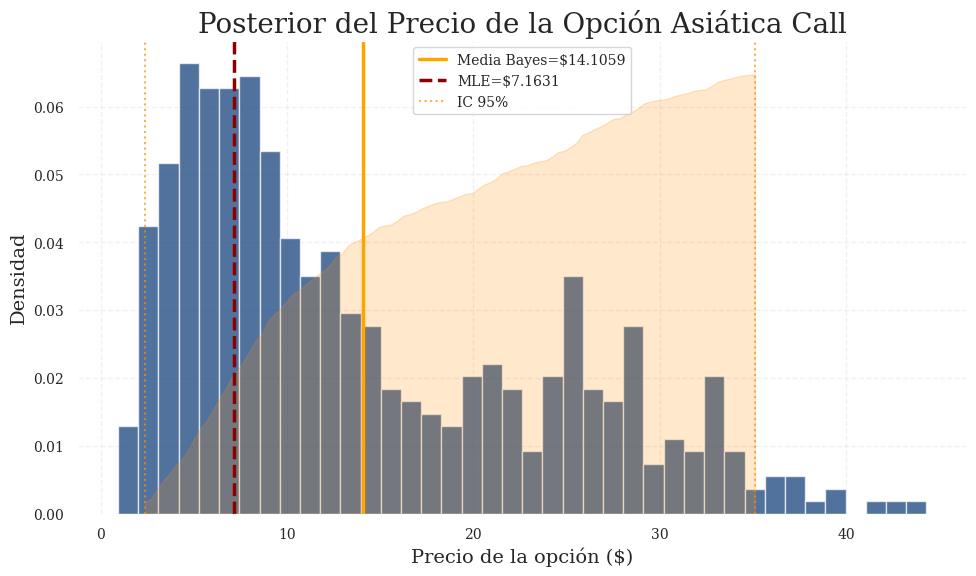

In [17]:
fig5, ax = plt.subplots(figsize=(10, 6))

ax.hist(precios_opcion, bins=40, density=True, alpha=0.7)
# add fill to the area under the curve between precio_ci[0] and precio_ci[1]
x = np.linspace(precio_ci[0], precio_ci[1], 100)
ax.fill_between(x, 0, np.interp(x, np.sort(precios_opcion), np.linspace(0, 1, len(precios_opcion)))* max(np.histogram(precios_opcion, bins=40, density=True)[0]), color='darkorange', alpha=0.2)
ax.axvline(precio_medio, linewidth=2.5, label=f"Media Bayes=${precio_medio:.4f}", color='orange')
ax.axvline(precio_mle, linestyle="--", linewidth=2.5, label=f"MLE=${precio_mle:.4f}", color='darkred')
ax.axvline(precio_ci[0], linestyle=":", linewidth=1.5, alpha=0.7, color='darkorange')
ax.axvline(precio_ci[1], linestyle=":", linewidth=1.5, alpha=0.7, label="IC 95%", color='darkorange')

ax.set_xlabel("Precio de la opción ($)")
ax.set_ylabel("Densidad")
ax.set_title("Posterior del Precio de la Opción Asiática Call")
ax.legend()
ax.grid(True, alpha=0.3)

fig5.tight_layout()
fig5_path = figures_dir / "fig5_precio_opcion_posterior.pdf"
fig5.savefig(fig5_path, bbox_inches="tight")

plt.show()


Se valora una opción asiática call de promedio aritmético continuo con:

- $S_0=100$, $K=100$ (at-the-money)
- $T=1$ año
- tasa libre de riesgo $r=0.03$

El payoff es
$$
\text{Payoff}=\max(\bar S_T-K,0),\qquad
\bar S_T=\frac{1}{T}\int_0^T S_t\,dt.
$$
En simulación discreta, $\bar S_T$ se aproxima por el promedio aritmético de la trayectoria diaria.

**Propagación de incertidumbre paramétrica.**  
En lugar de fijar $(\mu,\sigma)$, se toma una submuestra posterior $\{(\mu^{(i)},\sigma^{(i)})\}_{i=1}^M$ y para cada par se calcula un precio Monte Carlo:
$$
C^{(i)}=e^{-rT}\,\mathbb E_{\mu^{(i)},\sigma^{(i)}}[\max(\bar S_T-K,0)].
$$
Esto produce una distribución posterior del precio $p(C\mid \mathbf r)$, no un solo número.

**Lectura de la posterior del precio (Figura “Posterior del Precio…”).**

La distribución de precios es muy dispersa y con cola derecha pesada. El mecanismo es directo:

1. $\bar S_T$ depende fuertemente de la tendencia de la trayectoria.
2. La tendencia depende principalmente de $\mu$.
3. Como la posterior de $\mu$ es amplia, hay no-negligible masa en valores altos de $\mu$.
4. Esas realizaciones generan trayectorias crecientes con promedios muy superiores a $K$, disparando el payoff.

Por eso el precio bayesiano presenta:
- mayor media que MLE,
- mucha mayor desviación estándar,
- intervalos creíbles amplios.

**Comparación conceptual.**
- **MLE (puntual):** valora con $(\hat\mu_{\text{MLE}},\hat\sigma_{\text{MLE}})$, ignorando dispersión paramétrica.  
- **Bayes (distribucional):** integra sobre la incertidumbre; por convexidad del payoff, la cola derecha de $\mu$ eleva $E[C]$.

Resultado: **la incertidumbre en $\mu$ se traduce en riesgo de pricing sustancial para derivados dependientes de promedios.**


# Interpretación actuarial y gestión de riesgo

Desde una perspectiva actuarial/regulatoria, el hallazgo clave es que el precio de la opción no es un escalar sino una variable aleatoria inducida por incertidumbre de modelo. Esto afecta:

## Subestimación de riesgo con enfoques puntuales
El método MLE entrega un precio $C_{\text{MLE}}$ “promedio” que **no incorpora** variabilidad de parámetros. En mercados reales, donde $\mu$ es inherentemente incierto, esto equivale a suponer falsamente que el actuario conoce la medida física con precisión.

En contraste, la inferencia bayesiana produce un intervalo creíble $[C_{2.5\%},C_{97.5\%}]$ que cuantifica riesgo de modelo. La presencia de una cola derecha pesada implica que eventos de “precio extremo” no son raros bajo la posterior.

## Implicaciones para capital y reservas
Supón que una institución vende esta opción. Bajo Solvencia II/ORSA, el capital debe cubrir escenarios adversos razonables. Un criterio simple es usar percentiles altos del precio posterior como capital económico:

- **VaR de pricing al 95%:** $ \text{VaR}_{95\%}=C_{95\%}\approx C_{97.5\%}$ si se quiere ser conservador.
- **Expected Shortfall (ES):**
$$
\text{ES}_{95\%}= \mathbb E[C\mid C>\text{VaR}_{95\%}],
$$
que capta severidad media de la cola (más coherente para riesgos con colas pesadas).

Si solo se reserva $C_{\text{MLE}}$, el riesgo de insuficiencia de reservas aumenta, porque no se cubren trayectorias con $\mu$ alto que inflan el payoff.

## Sensibilidad estructural al drift
El ejercicio muestra una sensibilidad cualitativa: **derivados path-dependent de promedio aritmético amplifican la incertidumbre en tendencia**. Incluso si $\sigma$ se estima bien, la dispersión de $\mu$ domina el comportamiento del precio.

Esto generaliza a otros contratos donde la convexidad respecto a la tendencia es fuerte (p.ej., opciones lookback, cliquet, o ciertos productos de tasa).

**Mensaje actuarial:** *no basta estimar parámetros; hay que valorar el costo de no conocerlos.*


# Limitaciones y trabajo futuro

1. **Random-walk y alta autocorrelación.**  
La propuesta simétrica con SD fija lleva a pasos pequeños y exploración lenta para $\mu$. Técnicas potenciales:
   - ajustar SD objetivo a aceptación 40–60%,
   - propuestas adaptativas (AMH),
   - reparametrización para reducir correlación posterior,
   - HMC/NUTS para usar gradientes.

2. **Datos sintéticos.**  
La simulación GBM es útil para validación, pero mercados reales muestran:
   - volatilidad estocástica,
   - colas pesadas,
   - saltos,
   - cambios de régimen.
   Extender a Heston o Merton permitiría estudiar robustez.

3. **Promedio continuo aproximado discretamente.**  
La valoración asume discretización diaria; para activos intradiarios o commodities, muestreos más finos pueden alterar $\bar S_T$ y el precio.

4. **Priors débiles.**  
Aquí no dominaron los datos para $\mu$. Priors acturiales informativos (basados en historia larga o benchmarks) pueden reducir dispersión, pero deben justificarse con cuidado para evitar sesgo.

**Predicción testable:** al usar datos reales con alta volatilidad episódica, la posterior de $\sigma$ se ensanchará y el precio posterior tendrá colas aún más pesadas.


# Conclusiones

- Se implementó Metropolis–Hastings para inferir $(\mu,\sigma)$ en un GBM desde log-retornos. La cadena converge y produce una posterior coherente con los valores verdaderos.

- El parámetro $\sigma$ es estimado con alta precisión (posterior estrecha, ESS alto). Esto confirma que la volatilidad es identificable con relativa facilidad.

- El drift $\mu$ permanece altamente incierto y con mezcla lenta. Esto no es solo un problema algorítmico: refleja el límite estadístico de inferir tendencia con horizonte anual corto.

- Al valorar una opción asiática call, la incertidumbre en $\mu$ se propaga de forma no lineal al precio, generando una distribución posterior muy dispersa. El enfoque puntual MLE subestima riesgo de pricing.

- Actuarialmente, el precio posterior debe interpretarse como una medida de riesgo de modelo. Reservas/capital deben considerar percentiles altos o ES, no solo la media.

La inferencia bayesiana no solo da un precio, sino el rango de precios compatible con la realidad observada; ese rango es la pieza clave para decisiones prudentes.
